In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, butter, filtfilt

In [4]:
# Data Loading

ecg1, ppg1 = np.load('data/first_ecg.npy'), np.load('data/first_ppg.npy')
ecg2, ppg2 = np.load('data/second_ecg.npy'), np.load('data/second_ppg.npy')
ecg3, ppg3 = np.load('data/third_ecg.npy'), np.load('data/third_ppg.npy')

### Task 1: Sampling frequencies detection

The normal resting heart rate is known to be in range 60 to 100 bits per minute (bpm). We will use this rande to estimate the sample frequencies.

But firstly, let's visualize the data

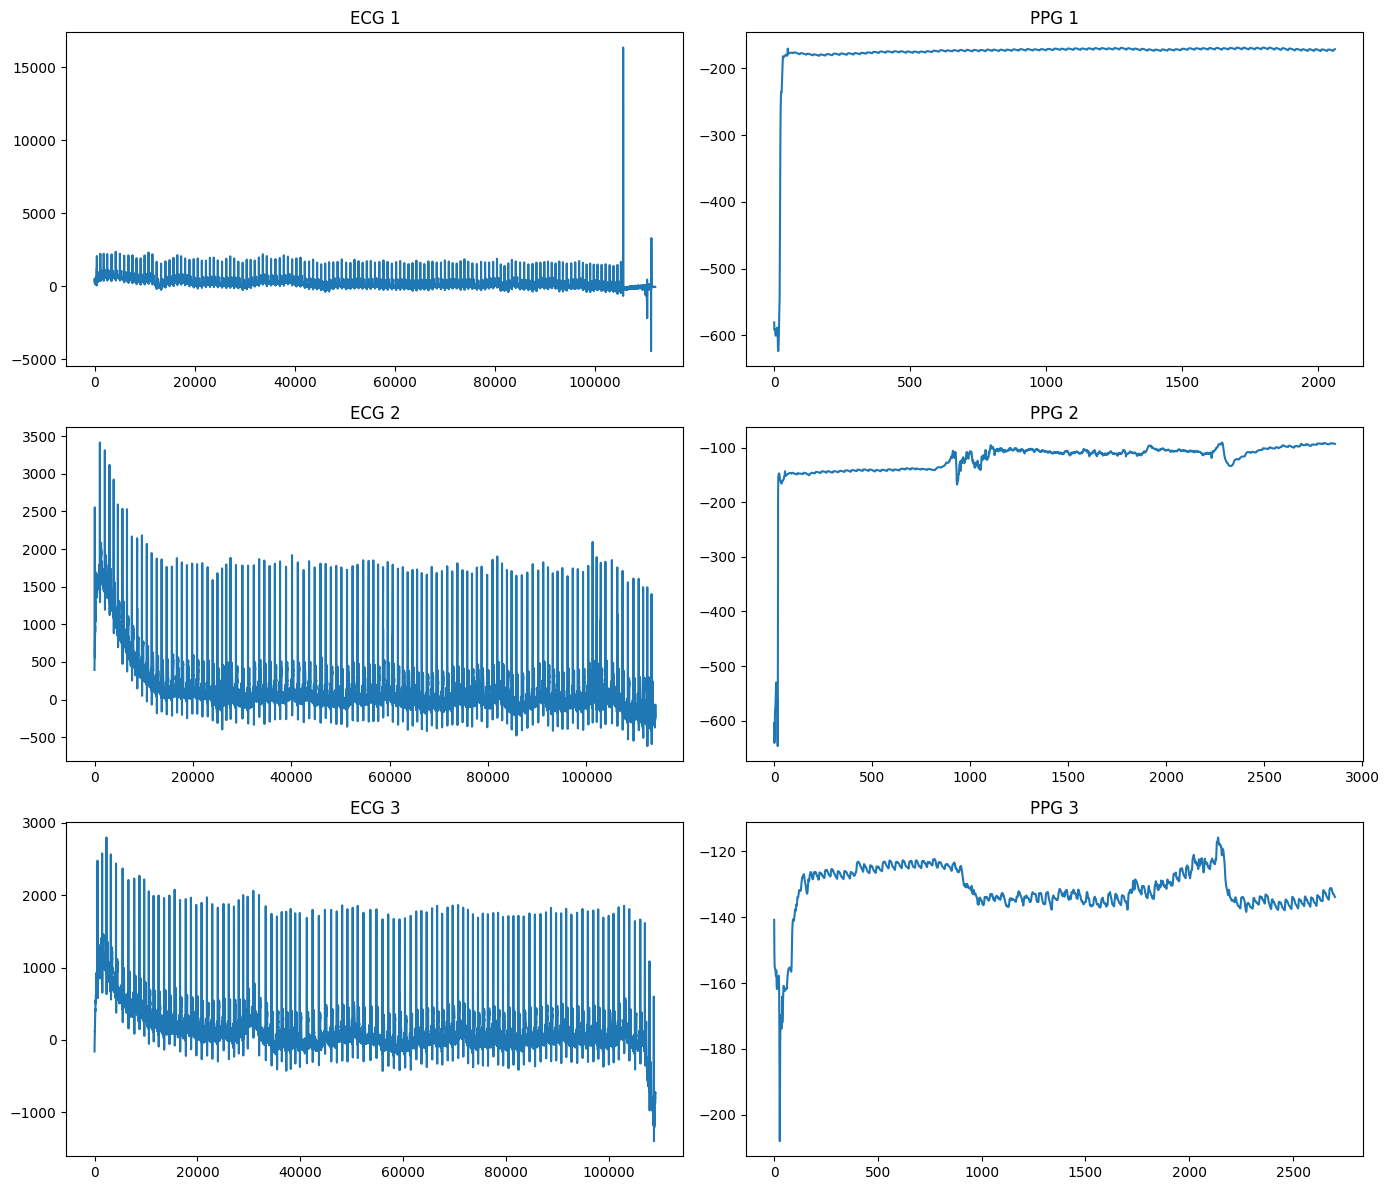

In [5]:
# Create the plots
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Plot ECG and PPG for the first dataset
axs[0, 0].plot(ecg1)
axs[0, 0].set_title('ECG 1')
axs[0, 1].plot(ppg1)
axs[0, 1].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1, 0].plot(ecg2)
axs[1, 0].set_title('ECG 2')
axs[1, 1].plot(ppg2)
axs[1, 1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2, 0].plot(ecg3)
axs[2, 0].set_title('ECG 3')
axs[2, 1].plot(ppg3)
axs[2, 1].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

To estimate the sampling frequency we will use the following relation:

$$F_s = \frac{N}{T}$$

where $N$ is a distance between two peaks and $T = X \; bps$ is a typical time between the peaks.

For the whole dataset, we will use 

$$\hat{F_s} = \frac{\sum \limits_{all \; peaks}N}{n*Xbps}$$
where $n$ is a number of peaks in the dataset.

ECG: R peaks and RR intervals

PPG: Systolic peaks and intervals between them.

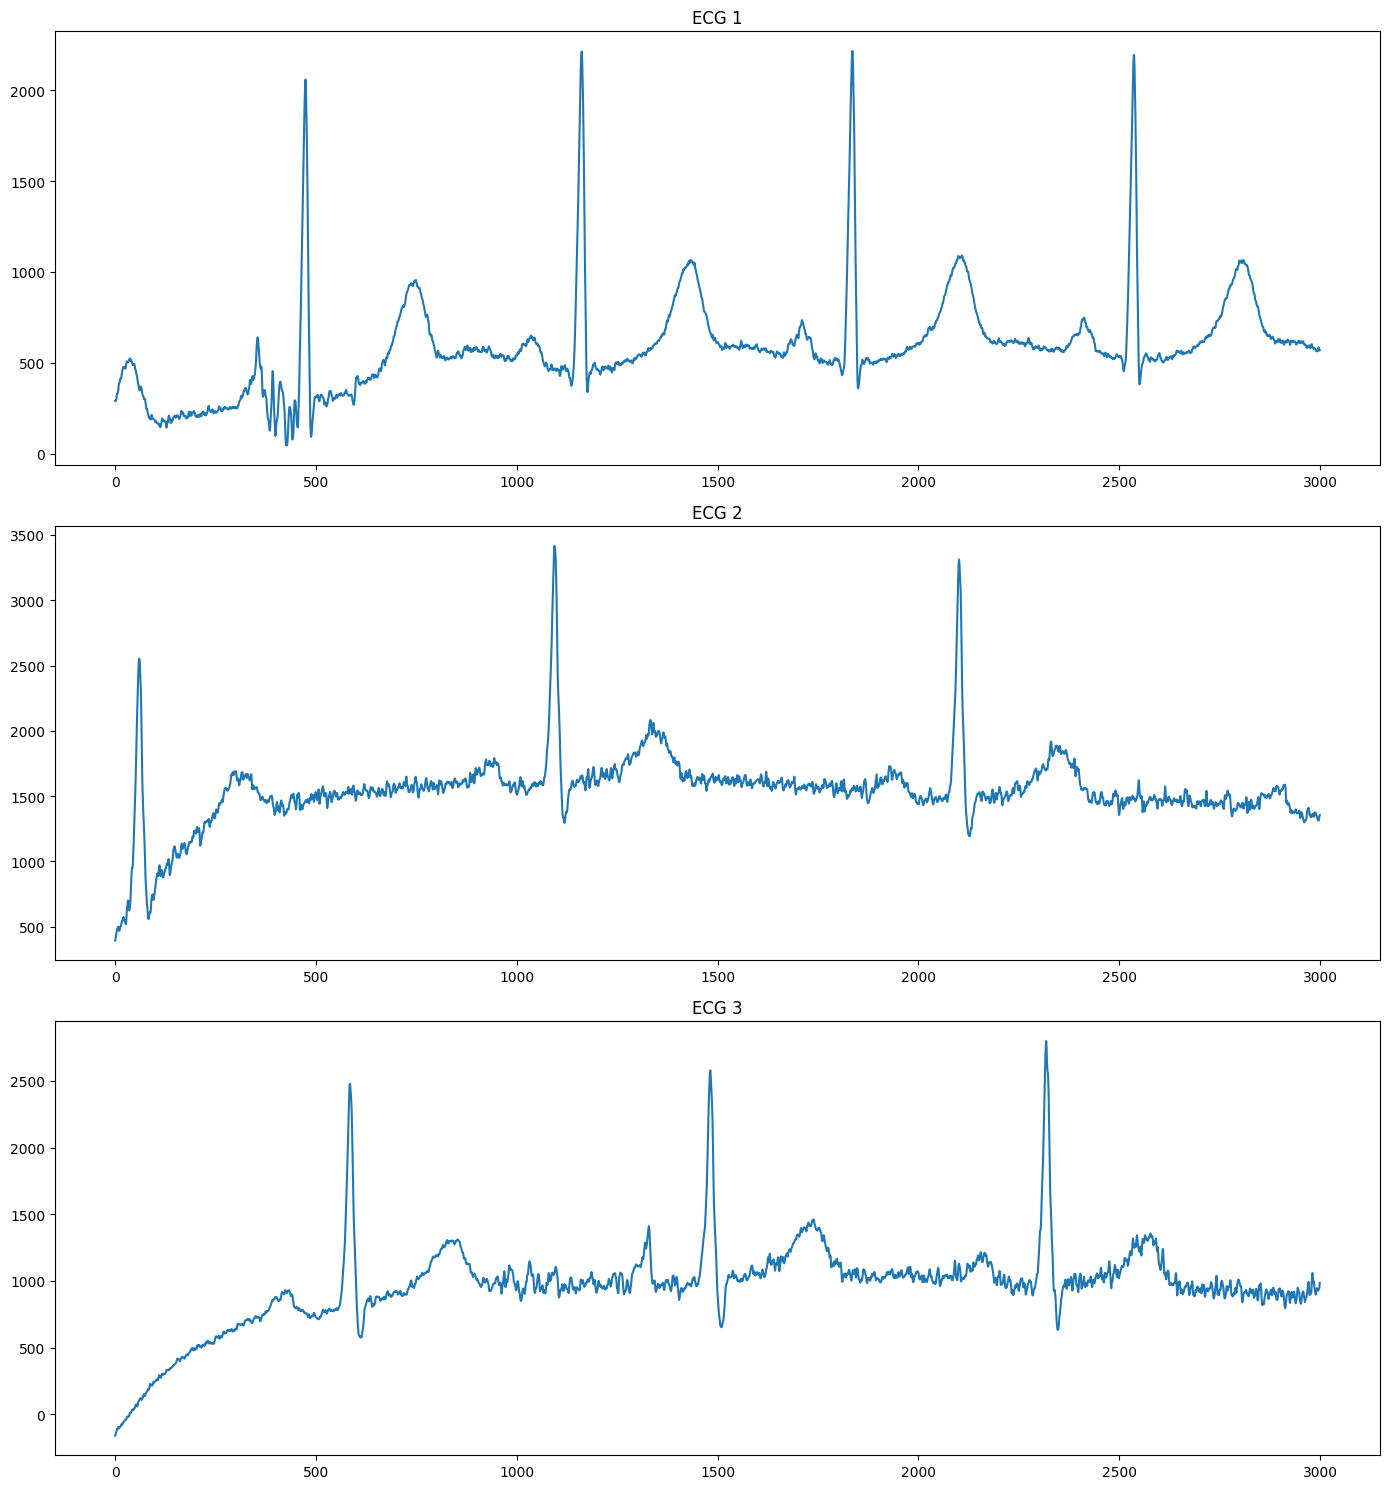

In [6]:
# Looking deeply at the data -- let's see the ECG peaks

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ecg1[:3000])
axs[0].set_title('ECG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ecg2[:3000])
axs[1].set_title('ECG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ecg3[:3000])
axs[2].set_title('ECG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

Looking at three ECG plots, we may assume that typical RR-interval for ECG1 is $\sim 700$ samples, for ECG2 is $\sim 1000$ samples and $\sim 900$ for ECG3

In [7]:
def detect_sampling_freq(data, bps, distance=None):
    peaks, _ = find_peaks(data, distance=distance)
    sum_interval = np.sum(np.diff(peaks))
    n = len(peaks)
    frequency = sum_interval / n / bps
    return frequency

In [17]:
ecg1_sf = detect_sampling_freq(ecg1, 1, 700)
print(f'The first ECG sampling frequency is ~{ecg1_sf} Hz')

ecg2_sf = detect_sampling_freq(ecg1, 1, 1000)
print(f'The Second ECG sampling frequency is ~{ecg2_sf} Hz')

ecg3_sf = detect_sampling_freq(ecg1, 1, 900)
print(f'The third ECG sampling frequency is ~{ecg3_sf} Hz')

The first ECG sampling frequency is ~807.927536231884 Hz
The Second ECG sampling frequency is ~1419.8846153846155 Hz
The third ECG sampling frequency is ~1419.8846153846155 Hz


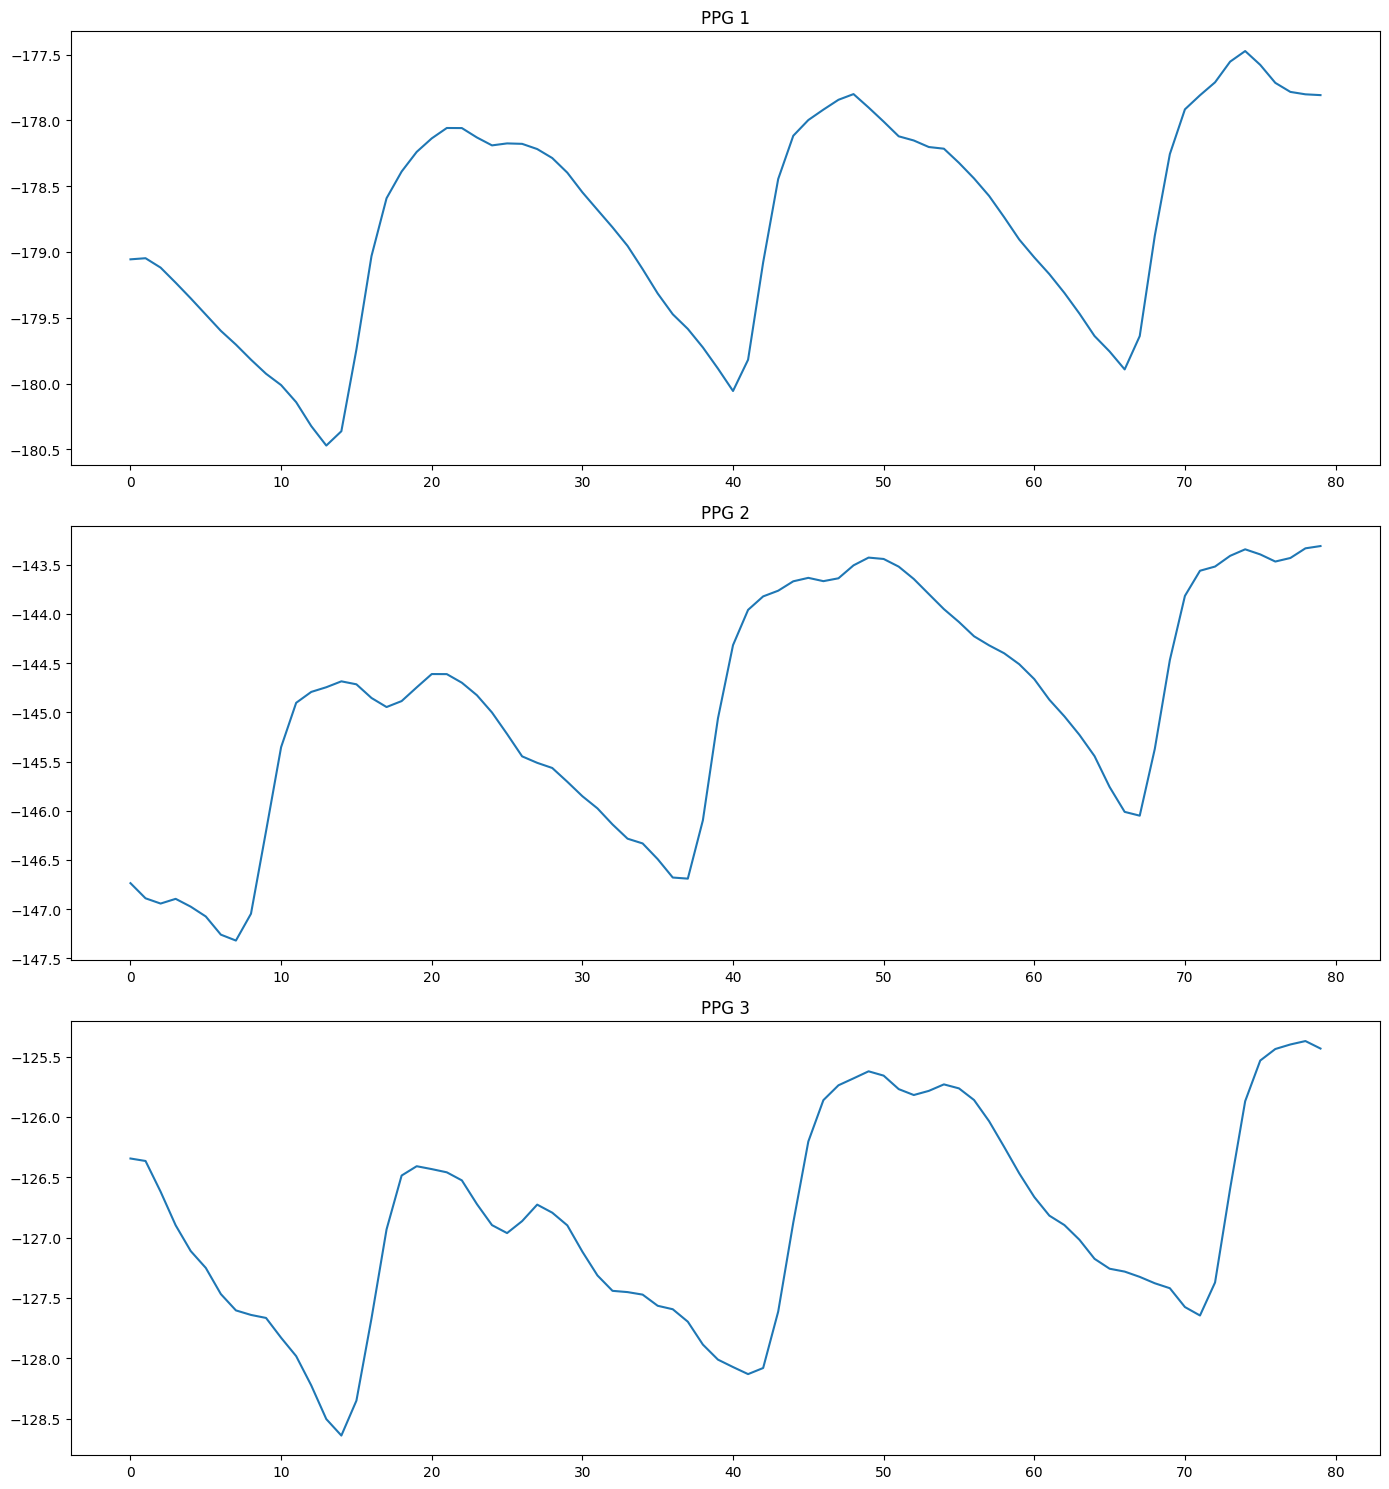

In [9]:
# PPG 

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ppg1[200:280])
axs[0].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ppg2[200:280])
axs[1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ppg3[200:280])
axs[2].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

For all PPGs the distance is $\sim 30$ samples

In [16]:
ppg1_sf = detect_sampling_freq(ppg1, 1, 30)
print(f'The first ECG sampling frequency is ~{ppg1_sf} Hz')

ppg2_sf = detect_sampling_freq(ppg2, 1, 30)
print(f'The Second ECG sampling frequency is ~{ppg1_sf} Hz')

ppg3_sf = detect_sampling_freq(ppg3, 1, 30)
print(f'The third ECG sampling frequency is ~{ppg2_sf} Hz')

The first ECG sampling frequency is ~50.7 Hz
The Second ECG sampling frequency is ~50.7 Hz
The third ECG sampling frequency is ~38.54794520547945 Hz


### Task 2: Preprocess the signals to remove high frequency noise, offset and trend.

In [11]:
# preprocessing functions

# Remove DC Offset
def remove_dc_offset(signal):
    mean = np.mean(signal)
    return signal - mean

# Lowpass Filter
def lowpass_filter(signal, cutoff, fs, order=5):
    # Nyquist normalization
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Remove Trend
def remove_trend_differencing(signal):
    detrended_signal = np.diff(signal, prepend=signal[0])
    return detrended_signal

# Full Signal Preprocessing
def preprocess_signal(signal, fs, cutoff):
    signal = remove_dc_offset(signal)
    signal = lowpass_filter(signal, cutoff, fs)
    return signal

# Full Signal Preprocessing
def preprocess_signal(signal, fs, cutoff):
    # Step 1: Remove DC Offset
    signal_no_dc = remove_dc_offset(signal)
    
    # Step 2: Apply Lowpass Filter
    filtered_signal = lowpass_filter(signal_no_dc, cutoff, fs)
    
    # Step 3: Remove Trend
    preprocessed_signal = remove_trend_differencing(filtered_signal)
    
    return preprocessed_signal

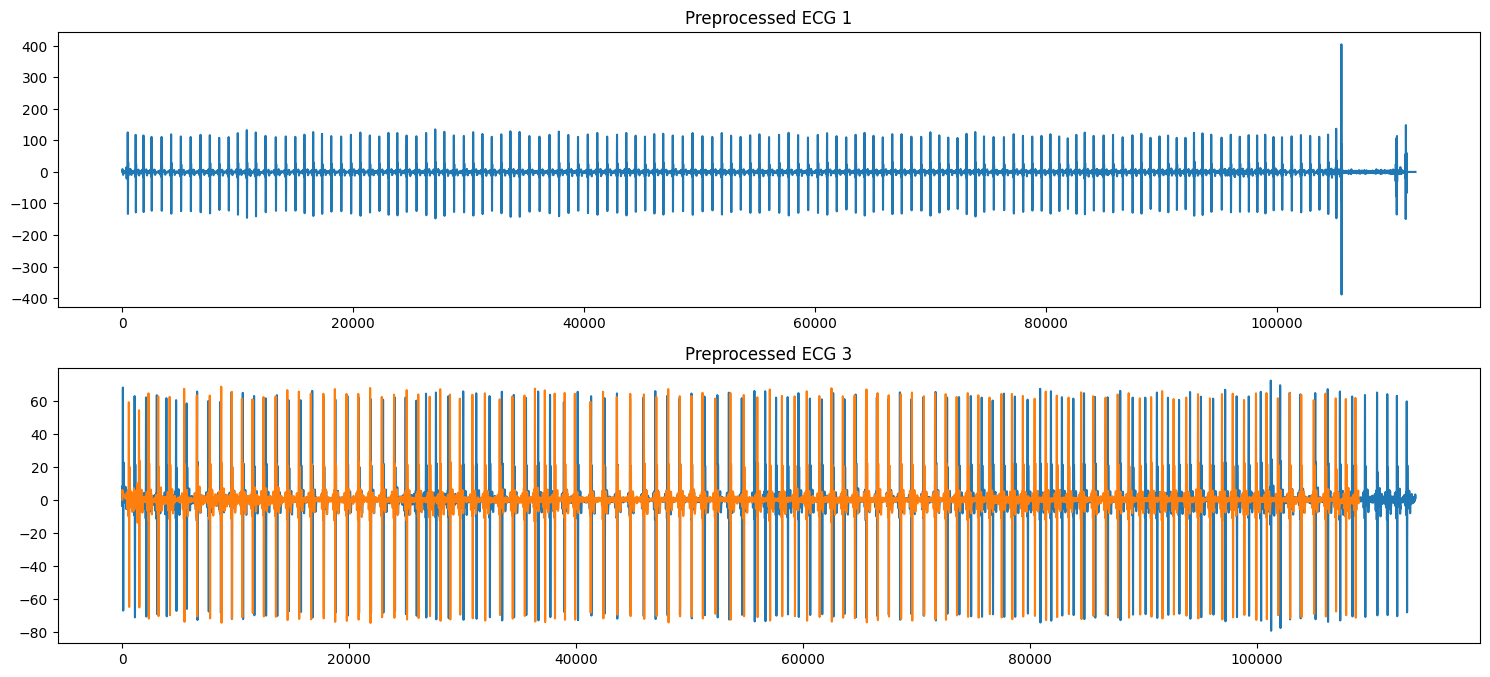

In [21]:
# Параметры фильтра
cutoff = 30.0  # Гц, частота среза для удаления высокочастотного шума

# Предобработка сигналов
ecg1_preprocessed = preprocess_signal(ecg1, ecg1_sf, cutoff)
ecg2_preprocessed = preprocess_signal(ecg2, ecg2_sf, cutoff)
ecg3_preprocessed = preprocess_signal(ecg3, ecg3_sf, cutoff)

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(ecg1_preprocessed)
plt.title('Preprocessed ECG 1')

plt.subplot(3, 1, 2)
plt.plot(ecg2_preprocessed)
plt.title('Preprocessed ECG 2')

plt.subplot(3, 1, 2)
plt.plot(ecg3_preprocessed)
plt.title('Preprocessed ECG 3')

plt.tight_layout()
plt.show()

### Task 3: Puls location

### Task 4: Anomalies and outliers detection

### Task 5: Sygnals synchronization

### Task 6: PPG evaluation